## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Load Everything

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
'{DATA_PATH}\\train.csv'

'{DATA_PATH}\\train.csv'

In [5]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [6]:
#imputed_train = pd.read_csv('../input/imputed/imputed_4_correlated_train.csv',dtype = train_dtypes)

#imputed_test = pd.read_csv('../input/imputed/imputed_4_correlated_test.csv',dtype = train_dtypes)
# imputed_test['molecule_index'] = imputed_test.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')

In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


### Создаем full

In [23]:
%%time
#full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
#full = map_atom_info(full, 1)
#full['inv_1_0'] = 1 / full.d_1_0
print(full.shape)

(43363, 73)
Wall time: 1.35 s


In [24]:
full.head(15)

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.017257,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,0.012545,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.027377,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,0.017257,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,0.012545,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.027377,NaN,NaN,NaN,NaN,NaN,NaN,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,1,6,8,1,0,0,0,0,-0.908377,0.046467,1.071835,-0.961441,NaN,NaN,NaN,NaN,1.826796,-0.011743,-0.652588,-0.475004,NaN,NaN,NaN,NaN,0.018920,0.001204,-0.011133,0.008074,NaN,NaN,NaN,NaN,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,1,6,1,8,0,0,0,0,0.825355,0.046467,-0.961441,1.071835,NaN,NaN,NaN,NaN,1.885049,-0.011743,-0.475004,-0.652588,NaN,NaN,NaN,NaN,0.003738,0.001204,0.008074,-0.011133,NaN,NaN,NaN,NaN,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,19,7,2,54.063999,1.984051,-0.131759,0.386749,1.178267,-0.633243,0.056917,1,6,6,1,8,1,1,0,1.190494,-0.027404,0.006799,0.913903,-1.037220,-0.028261,-0.870809,NaN,-1.639196,-0.017521,1.499697,1.929238,-0.639807,1.785173,1.911242,NaN,0.100062,-0.148948,-0.025670,-0.461001,-0.407276,1.031491,-0.523452,NaN,1.004771,1.727509,1.006952,2.084700,1.369356,2.043309,2.596395,2.434870,3.357022,1.522602,2.472166,2.627629,3.622846,2.184789,3.164912,2.263603,2.493768,1.213961,2.853019,2.873019,3.752229,2.154795,3.626644,3.318123,4.152511,2.138156,NaN,NaN,NaN,NaN
6,229,19,8,2,56.186001,1.190494,-1.639196,0.100062,1.178267,-0.633243,0.056917,1,6,8,6,1,1,1,0,1.984051,-0.027404,-1.037220,0.006799,0.913903,-0.028261,-0.870809,NaN,-0.131759,-0.017521,-0.639807,1.499697,1.929238,1.785173,1.911242,NaN,0.386749,-0.148948,-0.407276,-0.025670,-0.461001,1.031491,-0.523452,NaN,1.006952,1.727509,1.004771,2.043309,1.369356,2.084700,2.493768,2.263603,3.164912,1.213961,3.357022,2.434870,2.596395,1.522602,3.622846,2.627629,2.472166,2.184789,3.752229,2.873019,2.853019,2.154795,4.152511,3.318123,3.626644,2.138156,NaN,NaN,NaN,NaN
7,389,32,4,0,37.719002,0.917298,1.835475,0.052027,-0.036081,1.487625,0.036781,1,6,1,1,6,7,0,0,-0.471622,-0.010395,0.528271,0.489462,-1.371810,-2.440267,NaN,NaN,1.856772,0.025176,-0.345333,-0.408804,-0.521089,-0.959564,NaN,NaN,-0.802756,-0.015066,0.864695,-0.897152,0.027393,0.033705,NaN,NaN,1.014969,1.631013,1.015277,2.035264,1.463593,2.046443,2.359597,2.088941,2.937592,1.096093,2.474020,2.178272,2.462809,1.102846,3.285424,2.412301,2.674642,1.46753

## Check Regressions with the smallest type

In [25]:
full.describe()

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
count,4.336300e+04,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43360.000000,43360.000000,43358.000000,43358.000000,43344.000000,43308.000000,43363.000000,43363.000000,43360.000000,43360.000000,43358.000000,43358.000000,43344.000000,43308.000000,43363.000000,43363.000000,43360.000000,43360.000000,43358.000000,43358.000000,43344.000000,43308.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43363.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43358.000000,43358.000000,43358.000000,43358.000000,43358.000000,43358.000000,43358.000000,43358.000000,43344.000000,43344.000000,43344.000000,43344.000000,43308.000000,43308.000000,43308.000000,43308.000000
mean,2.198234e+06,65434.524756,12.923160,3.895948,47.479759,0.091999,-0.441423,0.042376,0.040461,-0.422912,0.061446,4.227567,5.989991,4.012522,4.335101,4.545995,4.704725,4.586468,4.165787,0.041628,0.040654,-0.059226,-0.081467,-0.064798,-0.085965,-0.092530,-0.080505,-0.442929,-0.571798,-0.704129,-0.586016,-0.516632,-0.509392,-0.509939,-0.541827,0.032019,0.027745,0.029362,0.023051,0.034178,0.020153,0.021298,0.025654,1.012870,1.897413,1.246102,2.117010,1.546494,1.977022,2.567342,2.301477,2.522500,1.747167,2.844029,2.453634,2.503321,2.061568,3.138544,2.603128,2.558175,2.146780,3.367334,2.828982,2.748088,2.326204,3.608717,3.082334,3.038860,2.553383,3.863652,3.350242,3.289778,2.819575
std,1.515523e+06,41312.346152,3.299147,2.833244,10.922179,1.882968,2.216822,1.639822,1.568277,1.915419,1.342325,2.457641,1.068755,2.960692,2.808805,2.705708,2.561234,2.620600,2.782083,1.563036,1.347177,1.681857,1.605490,1.542319,1.519733,1.505695,1.547518,1.943257,1.638867,1.898016,1.785227,1.745031,1.731126,1.792797,1.866796,1.348814,1.083671,1.367205,1.224680,1.196597,1.159346,1.162401,1.217317,0.005905,0.176119,0.188682,0.139421,0.323907,0.373816,0.294949,0.199961,0.889891,0.773341,0.444928,0.296121,0.847415,0.875868,0.487785,0.411497,0.799557,0.837541,0.572098,0.528225,0.935920,0.750804,0.658369,0.603189,0.978863,0.748866,0.722620,0.671784,1.021731,0.767128
min,1.000000e+01,2.000000,0.000000,0.000000,24.322201,-7.942035,-8.038531,-6.738569,-7.019292,-7.021652,-5.925428,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.735908,-6.681067,-7.045639,-6.947312,-6.723586,-7.933076,-7.113124,-7.653444,-7.152598,-7.249749,-7.186690,-7.084982,-7.313498,-7.131220,-7.056660,-6.982985,-6.142562,-5.898220,-6.519874,-5.525993,-6.750299,-5.831831,-5.852950,-6.716642,1.002241,1.601385,1.002574,1.618706,1.015208,1.085291,1.580508,1.463678,1.073877,1.004206,1.430608,1.830691,1.073825,0.963143,1.872553,1.839071,1.077776,0.986151,1.781951,1.986521,1.079562,0.969162,1.841153,2.005261,1.083102,1.007480,1.894571,2.056098,1.083705,0.960715
25%,8.300095e+05,28605.500000,10.000000,1.000000,36.496799,-0.986348,-2.189568,-0.823952,-0.675882,-1.923885,-0.474631,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.831398,-0.329294,-1.157406,-1.184084,-1.148473,-1.154850,-1.102086,-1.062709,-1.923573,-1.858923,-2.026626,-1.843666,-1.842057,-1.946079,-2.008535,-2.080458,-0.559958,-0.212970,-0.645973,-0.544174,-0.591870,-0.549217,-0.549627,-0.628553,1.007826,1.709706,1.013290,2.035813,1.381317,1.515919,2.354764,2.149570,1.511265,1.096614,2.502577,2.228416,1.556467,1.370479,2.759854

We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [26]:
df = take_n_atoms(full, 7)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [27]:
df.head()

,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,0,0,0,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.688900
1,1,1,0,0,0,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.689098
2,1,1,0,0,0,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.690498
3,1,6,8,1,0,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,0.0,0.0,0.0,0.0,55.525200
4,1,6,1,8,0,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,0.0,0.0,0.0,0.0,54.735901


In [28]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 23), (8673, 23), (34690,), (8673,))

## CatBoost

In [29]:
from catboost import CatBoostRegressor

In [30]:
params = {
          'learning_rate': 0.5,
           'max_depth': 3,    
           'n_estimators': 1000
         }
#categorical features
categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **params, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 47.2189354	test: 47.2745386	best: 47.2745386 (0)	total: 74.2ms	remaining: 1m 14s
1:	learn: 46.9691057	test: 47.0247378	best: 47.0247378 (1)	total: 90.6ms	remaining: 45.2s
2:	learn: 46.7192353	test: 46.7748677	best: 46.7748677 (2)	total: 114ms	remaining: 38s
3:	learn: 46.4694080	test: 46.5250436	best: 46.5250436 (3)	total: 134ms	remaining: 33.4s
4:	learn: 46.2195375	test: 46.2751707	best: 46.2751707 (4)	total: 153ms	remaining: 30.4s
5:	learn: 45.9696670	test: 46.0252996	best: 46.0252996 (5)	total: 170ms	remaining: 28.2s
6:	learn: 45.7198398	test: 45.7754712	best: 45.7754712 (6)	total: 188ms	remaining: 26.7s
7:	learn: 45.4699694	test: 45.5256018	best: 45.5256018 (7)	total: 204ms	remaining: 25.3s
8:	learn: 45.2201422	test: 45.2757735	best: 45.2757735 (8)	total: 223ms	remaining: 24.6s
9:	learn: 44.9703150	test: 45.0259454	best: 45.0259454 (9)	total: 240ms	remaining: 23.7s
10:	learn: 44.7204380	test: 44.7760742	best: 44.7760742 (10)	total: 259ms	remaining: 23.3s
11:	learn: 44.4705

95:	learn: 23.4763315	test: 23.5319914	best: 23.5319914 (95)	total: 1.58s	remaining: 14.9s
96:	learn: 23.2263747	test: 23.2820345	best: 23.2820345 (96)	total: 1.6s	remaining: 14.9s
97:	learn: 22.9764179	test: 23.0321172	best: 23.0321172 (97)	total: 1.61s	remaining: 14.8s
98:	learn: 22.7264612	test: 22.7822181	best: 22.7822181 (98)	total: 1.62s	remaining: 14.8s
99:	learn: 22.4765044	test: 22.5323750	best: 22.5323750 (99)	total: 1.64s	remaining: 14.7s
100:	learn: 22.2265476	test: 22.2825337	best: 22.2825337 (100)	total: 1.65s	remaining: 14.7s
101:	learn: 21.9765909	test: 22.0326923	best: 22.0326923 (101)	total: 1.66s	remaining: 14.6s
102:	learn: 21.7266341	test: 21.7828508	best: 21.7828508 (102)	total: 1.67s	remaining: 14.6s
103:	learn: 21.4766773	test: 21.5330094	best: 21.5330094 (103)	total: 1.69s	remaining: 14.5s
104:	learn: 21.2267206	test: 21.2831680	best: 21.2831680 (104)	total: 1.7s	remaining: 14.5s
105:	learn: 20.9767638	test: 21.0333266	best: 21.0333266 (105)	total: 1.71s	remain

185:	learn: 6.0270540	test: 6.1205016	best: 6.1205016 (185)	total: 3.05s	remaining: 13.3s
186:	learn: 5.9059253	test: 5.9991730	best: 5.9991730 (186)	total: 3.06s	remaining: 13.3s
187:	learn: 5.7858364	test: 5.8792523	best: 5.8792523 (187)	total: 3.08s	remaining: 13.3s
188:	learn: 5.6674083	test: 5.7611391	best: 5.7611391 (188)	total: 3.1s	remaining: 13.3s
189:	learn: 5.5505340	test: 5.6442101	best: 5.6442101 (189)	total: 3.12s	remaining: 13.3s
190:	learn: 5.4339714	test: 5.5282290	best: 5.5282290 (190)	total: 3.13s	remaining: 13.3s
191:	learn: 5.3188623	test: 5.4133441	best: 5.4133441 (191)	total: 3.15s	remaining: 13.3s
192:	learn: 5.2044399	test: 5.2996873	best: 5.2996873 (192)	total: 3.17s	remaining: 13.2s
193:	learn: 5.0891984	test: 5.1842582	best: 5.1842582 (193)	total: 3.19s	remaining: 13.2s
194:	learn: 4.9776946	test: 5.0732895	best: 5.0732895 (194)	total: 3.2s	remaining: 13.2s
195:	learn: 4.8663814	test: 4.9612150	best: 4.9612150 (195)	total: 3.22s	remaining: 13.2s
196:	learn: 

281:	learn: 1.1707550	test: 1.1993905	best: 1.1993905 (281)	total: 4.72s	remaining: 12s
282:	learn: 1.1661949	test: 1.1950824	best: 1.1950824 (282)	total: 4.74s	remaining: 12s
283:	learn: 1.1615924	test: 1.1897512	best: 1.1897512 (283)	total: 4.76s	remaining: 12s
284:	learn: 1.1564625	test: 1.1837721	best: 1.1837721 (284)	total: 4.77s	remaining: 12s
285:	learn: 1.1522039	test: 1.1795467	best: 1.1795467 (285)	total: 4.8s	remaining: 12s
286:	learn: 1.1479252	test: 1.1750226	best: 1.1750226 (286)	total: 4.81s	remaining: 12s
287:	learn: 1.1450002	test: 1.1722348	best: 1.1722348 (287)	total: 4.83s	remaining: 11.9s
288:	learn: 1.1395481	test: 1.1665207	best: 1.1665207 (288)	total: 4.85s	remaining: 11.9s
289:	learn: 1.1333946	test: 1.1599376	best: 1.1599376 (289)	total: 4.87s	remaining: 11.9s
290:	learn: 1.1281847	test: 1.1544982	best: 1.1544982 (290)	total: 4.88s	remaining: 11.9s
291:	learn: 1.1243171	test: 1.1495003	best: 1.1495003 (291)	total: 4.9s	remaining: 11.9s
292:	learn: 1.1175053	te

378:	learn: 0.8897774	test: 0.9047737	best: 0.9047737 (378)	total: 6.4s	remaining: 10.5s
379:	learn: 0.8861801	test: 0.9016048	best: 0.9016048 (379)	total: 6.42s	remaining: 10.5s
380:	learn: 0.8845383	test: 0.9001350	best: 0.9001350 (380)	total: 6.44s	remaining: 10.5s
381:	learn: 0.8826919	test: 0.8983437	best: 0.8983437 (381)	total: 6.46s	remaining: 10.4s
382:	learn: 0.8818220	test: 0.8974691	best: 0.8974691 (382)	total: 6.47s	remaining: 10.4s
383:	learn: 0.8798816	test: 0.8959611	best: 0.8959611 (383)	total: 6.49s	remaining: 10.4s
384:	learn: 0.8789944	test: 0.8951519	best: 0.8951519 (384)	total: 6.51s	remaining: 10.4s
385:	learn: 0.8758917	test: 0.8920347	best: 0.8920347 (385)	total: 6.53s	remaining: 10.4s
386:	learn: 0.8735677	test: 0.8897848	best: 0.8897848 (386)	total: 6.54s	remaining: 10.4s
387:	learn: 0.8711587	test: 0.8875561	best: 0.8875561 (387)	total: 6.56s	remaining: 10.3s
388:	learn: 0.8692968	test: 0.8859224	best: 0.8859224 (388)	total: 6.58s	remaining: 10.3s
389:	learn:

476:	learn: 0.7637651	test: 0.7862045	best: 0.7862045 (476)	total: 8.11s	remaining: 8.89s
477:	learn: 0.7630339	test: 0.7859245	best: 0.7859245 (477)	total: 8.13s	remaining: 8.88s
478:	learn: 0.7620296	test: 0.7846435	best: 0.7846435 (478)	total: 8.15s	remaining: 8.86s
479:	learn: 0.7612664	test: 0.7835624	best: 0.7835624 (479)	total: 8.17s	remaining: 8.85s
480:	learn: 0.7608566	test: 0.7832987	best: 0.7832987 (480)	total: 8.18s	remaining: 8.83s
481:	learn: 0.7600810	test: 0.7823840	best: 0.7823840 (481)	total: 8.2s	remaining: 8.81s
482:	learn: 0.7590723	test: 0.7814317	best: 0.7814317 (482)	total: 8.22s	remaining: 8.8s
483:	learn: 0.7581793	test: 0.7805955	best: 0.7805955 (483)	total: 8.24s	remaining: 8.78s
484:	learn: 0.7570219	test: 0.7793145	best: 0.7793145 (484)	total: 8.25s	remaining: 8.77s
485:	learn: 0.7560938	test: 0.7783619	best: 0.7783619 (485)	total: 8.27s	remaining: 8.75s
486:	learn: 0.7557886	test: 0.7780895	best: 0.7780895 (486)	total: 8.29s	remaining: 8.73s
487:	learn: 

574:	learn: 0.7005849	test: 0.7281809	best: 0.7281809 (574)	total: 9.81s	remaining: 7.25s
575:	learn: 0.7002211	test: 0.7278412	best: 0.7278412 (575)	total: 9.83s	remaining: 7.24s
576:	learn: 0.6992783	test: 0.7270027	best: 0.7270027 (576)	total: 9.84s	remaining: 7.22s
577:	learn: 0.6988453	test: 0.7263802	best: 0.7263802 (577)	total: 9.86s	remaining: 7.2s
578:	learn: 0.6978379	test: 0.7257140	best: 0.7257140 (578)	total: 9.88s	remaining: 7.18s
579:	learn: 0.6972945	test: 0.7254875	best: 0.7254875 (579)	total: 9.89s	remaining: 7.17s
580:	learn: 0.6965132	test: 0.7249270	best: 0.7249270 (580)	total: 9.91s	remaining: 7.15s
581:	learn: 0.6959584	test: 0.7243116	best: 0.7243116 (581)	total: 9.93s	remaining: 7.13s
582:	learn: 0.6954195	test: 0.7236813	best: 0.7236813 (582)	total: 9.94s	remaining: 7.11s
583:	learn: 0.6949136	test: 0.7231092	best: 0.7231092 (583)	total: 9.96s	remaining: 7.1s
584:	learn: 0.6945538	test: 0.7227619	best: 0.7227619 (584)	total: 9.98s	remaining: 7.08s
585:	learn: 

671:	learn: 0.6544508	test: 0.6861870	best: 0.6861870 (671)	total: 11.5s	remaining: 5.6s
672:	learn: 0.6540222	test: 0.6857776	best: 0.6857776 (672)	total: 11.5s	remaining: 5.58s
673:	learn: 0.6537043	test: 0.6855774	best: 0.6855774 (673)	total: 11.5s	remaining: 5.57s
674:	learn: 0.6531717	test: 0.6849887	best: 0.6849887 (674)	total: 11.5s	remaining: 5.55s
675:	learn: 0.6530076	test: 0.6849626	best: 0.6849626 (675)	total: 11.5s	remaining: 5.53s
676:	learn: 0.6524261	test: 0.6844279	best: 0.6844279 (676)	total: 11.6s	remaining: 5.51s
677:	learn: 0.6520455	test: 0.6839565	best: 0.6839565 (677)	total: 11.6s	remaining: 5.5s
678:	learn: 0.6517068	test: 0.6836902	best: 0.6836902 (678)	total: 11.6s	remaining: 5.48s
679:	learn: 0.6508728	test: 0.6828245	best: 0.6828245 (679)	total: 11.6s	remaining: 5.46s
680:	learn: 0.6505595	test: 0.6826099	best: 0.6826099 (680)	total: 11.6s	remaining: 5.45s
681:	learn: 0.6503502	test: 0.6824533	best: 0.6824533 (681)	total: 11.6s	remaining: 5.43s
682:	learn: 

769:	learn: 0.6229433	test: 0.6587194	best: 0.6587194 (769)	total: 13.2s	remaining: 3.93s
770:	learn: 0.6225422	test: 0.6581008	best: 0.6581008 (770)	total: 13.2s	remaining: 3.91s
771:	learn: 0.6221707	test: 0.6579547	best: 0.6579547 (771)	total: 13.2s	remaining: 3.9s
772:	learn: 0.6219141	test: 0.6577187	best: 0.6577187 (772)	total: 13.2s	remaining: 3.88s
773:	learn: 0.6215321	test: 0.6574507	best: 0.6574507 (773)	total: 13.2s	remaining: 3.86s
774:	learn: 0.6213373	test: 0.6572332	best: 0.6572332 (774)	total: 13.2s	remaining: 3.84s
775:	learn: 0.6210145	test: 0.6568350	best: 0.6568350 (775)	total: 13.3s	remaining: 3.83s
776:	learn: 0.6208100	test: 0.6566038	best: 0.6566038 (776)	total: 13.3s	remaining: 3.81s
777:	learn: 0.6205864	test: 0.6564370	best: 0.6564370 (777)	total: 13.3s	remaining: 3.8s
778:	learn: 0.6202205	test: 0.6561983	best: 0.6561983 (778)	total: 13.3s	remaining: 3.78s
779:	learn: 0.6197344	test: 0.6558181	best: 0.6558181 (779)	total: 13.3s	remaining: 3.76s
780:	learn: 

862:	learn: 0.6008385	test: 0.6401455	best: 0.6401455 (862)	total: 14.8s	remaining: 2.35s
863:	learn: 0.6007125	test: 0.6400692	best: 0.6400692 (863)	total: 14.9s	remaining: 2.34s
864:	learn: 0.6005415	test: 0.6400168	best: 0.6400168 (864)	total: 14.9s	remaining: 2.32s
865:	learn: 0.6002865	test: 0.6397794	best: 0.6397794 (865)	total: 14.9s	remaining: 2.3s
866:	learn: 0.6002207	test: 0.6396703	best: 0.6396703 (866)	total: 14.9s	remaining: 2.29s
867:	learn: 0.5999500	test: 0.6395363	best: 0.6395363 (867)	total: 14.9s	remaining: 2.27s
868:	learn: 0.5998606	test: 0.6394433	best: 0.6394433 (868)	total: 14.9s	remaining: 2.25s
869:	learn: 0.5997794	test: 0.6393678	best: 0.6393678 (869)	total: 15s	remaining: 2.23s
870:	learn: 0.5995138	test: 0.6390884	best: 0.6390884 (870)	total: 15s	remaining: 2.22s
871:	learn: 0.5993611	test: 0.6388526	best: 0.6388526 (871)	total: 15s	remaining: 2.2s
872:	learn: 0.5989899	test: 0.6386329	best: 0.6386329 (872)	total: 15s	remaining: 2.18s
873:	learn: 0.598840

960:	learn: 0.5825124	test: 0.6237573	best: 0.6237573 (960)	total: 16.5s	remaining: 671ms
961:	learn: 0.5821143	test: 0.6233916	best: 0.6233916 (961)	total: 16.5s	remaining: 654ms
962:	learn: 0.5819371	test: 0.6232214	best: 0.6232214 (962)	total: 16.6s	remaining: 636ms
963:	learn: 0.5819316	test: 0.6232095	best: 0.6232095 (963)	total: 16.6s	remaining: 619ms
964:	learn: 0.5818987	test: 0.6231925	best: 0.6231925 (964)	total: 16.6s	remaining: 602ms
965:	learn: 0.5818506	test: 0.6231007	best: 0.6231007 (965)	total: 16.6s	remaining: 585ms
966:	learn: 0.5817746	test: 0.6230985	best: 0.6230985 (966)	total: 16.6s	remaining: 568ms
967:	learn: 0.5816869	test: 0.6230479	best: 0.6230479 (967)	total: 16.7s	remaining: 550ms
968:	learn: 0.5813962	test: 0.6226211	best: 0.6226211 (968)	total: 16.7s	remaining: 533ms
969:	learn: 0.5811682	test: 0.6223688	best: 0.6223688 (969)	total: 16.7s	remaining: 516ms
970:	learn: 0.5809984	test: 0.6221872	best: 0.6221872 (970)	total: 16.7s	remaining: 499ms
971:	learn

-0.48141794280153644

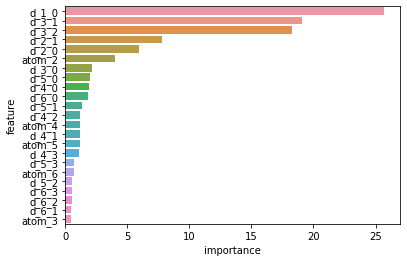

In [32]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [ ]:
X_train.describe()

## LGBMRegressor

In [ ]:
#aaa

In [ ]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 30,
    'min_child_samples': 79,
    'max_depth': 2,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [ ]:

model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Not a bad score for such a simple set of features.

In [ ]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model
do not need now

In [ ]:
asfasdfasdf

In [ ]:

def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [ ]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=600, n_jobs = -1)
        #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [ ]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 5
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

Checking cross-validation scores for each type:

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## Room for improvement

There are many steps, how to improve the score for this kernel:
* Tune LGB hyperparameters - I did nothing for this
* Tune number of atoms for each type
* Try to add other features
* Play with categorical features for atom types (one-hot-encoding, CatBoost?)
* Try other tree libraries

Also, this representation fails badly on `*JHC` coupling types. The main reason for this is that 3rd and 4th atoms are usually located on the same distance and representation starts "jittering" randomly picking one of them. So, two similar configurations will have different representation due to usage of 3/4 of 4/3 distances.

The biggest challenge would be to implement handcrafted KNN with some compiled language(Rust, C++, C).

Would be cool to see this kernel forked and addressed some of the issues with higher LB score.